In [340]:
from music21 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from fractions import Fraction
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.util import ngrams, skipgrams
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
import cPickle as pickle

# Load dictionaries with string tokens

In [2]:
with open('interval_dict.pkl', 'r') as picklefile:
    interval_dict = pickle.load(picklefile)
with open('duration_dict.pkl', 'r') as picklefile:
    duration_dict = pickle.load(picklefile)
with open('both_dict.pkl', 'r') as picklefile:
    both_dict = pickle.load(picklefile)

# Creating new labels for dicts

In [241]:
def new_label(inDict):
    return_dict = defaultdict(list)
    for origin, values in inDict.iteritems():
                # consolidate origins - less classes and mores samples

        if origin == 'gershwin' or origin == 'foster':
            origin = 'usa'
        elif origin == 'pawnee' or origin == 'ojibway' or origin == 'sioux':
            origin = 'Native American'
        elif origin == 'england' or origin == 'british' or origin == 'ireland' or origin == 'scotland':
            origin = 'england'
        elif origin == 'danmark' or origin == 'sverige':
            origin = 'Scandinavian'
        elif origin == 'romania' or origin == 'ukraina' or origin == 'jugoslav' or origin == 'polska' or origin == 'czech':
            origin = 'Eastern Europe'
        elif origin == 'magyar':
            origin = 'oesterrh'
        elif origin[:3] == 'lux':
            origin = 'luxemburg'
        elif origin == 'friuli':
            origin = 'italia'
        elif origin == 'lorraine' or origin == 'elsass' or origin == 'lothring':
            origin = 'france'
        elif origin == 'allerkbd' or origin == 'altdeu1' or origin == 'altdeu2' or origin == 'ballad' or origin == 'boehme' or origin == 'dva' or origin == 'erk' or origin == 'fink' or origin == 'kinder' or origin == 'variant' or origin == 'zuccal':
            origin = 'germany'
        elif origin == 'chinese' or origin == 'han' or origin == 'natmin' or origin == 'shanxi' or origin == 'xinhua':
            origin = 'china'
        elif len(values) < 10 or origin == 'pentatonic':
            continue
        return_dict[origin].extend(values)
    return return_dict

# Creating Term Matrices

In [3]:
def my_tokenizer(s):
    return s.split()

# tokenization and preprocessing was already accomplished parsing and stringifying the data
def my_tokenizer2(s):
    return s

def my_preprocessor(s):
    return s

In [341]:
def count_vectorize(parsed_dict, tokenizer=None, preprocessor=None, ngram_range=(1,1), limits=None):
    # takes in parsed_dict and vectorizer arguements to create count vectorizer. returns tuple of (sparse matrix, 
    # a vectorizer object, a list of origins for the observations)
    
    all_documents = []
    origins = []
    all_documents.extend(parsed_songs)
    origins.extend([origin]*len(parsed_songs))
    vectorizer = CountVectorizer(tokenizer=tokenizer, preprocessor=preprocessor, ngram_range=ngram_range)
    X = vectorizer.fit_transform(all_documents)
    features = vectorizer.get_feature_names()
    return (X, features, origins)

In [342]:
def to_dataframe(count_vectorized_tuple):
    df = pd.DataFrame(count_vectorized_tuple[0].toarray(), columns=count_vectorized_tuple[1])
    df['origin'] = count_vectorized_tuple[2]
    return df

# Confusion Matrix

In [343]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print(__doc__)

sns.set_style("whitegrid", {'axes.grid' : False})

# create confusion matrix for data

def plot_confusion_matrix(cm, y_test, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(pd.Series(y_test).unique()))
    plt.xticks(tick_marks, sorted(pd.Series(y_test).unique()), rotation=45, fontsize=14)
    plt.yticks(tick_marks, sorted(pd.Series(y_test).unique()), fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

def normalize_cm(cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm_normalized

Automatically created module for IPython interactive environment


# Incorporating Markov to oversample

In [8]:
import markov_model_05 as markov

In [12]:
def oversample(token_list, n_samples=10):
    size = int(np.array([len(tokens) for tokens in token_list]).mean())
    mark = markov.Markov(token_list)
    new_songs = []
    for i in range(n_samples):
        new_songs.append(mark.generate_markov_text(size=size))
    return new_songs

# Balancing datasets with Markov...

In [344]:
# after some testing - decided to upsample those which had data < 200 and random sample from those with data > 200
# this kept a fair class balance which when using sample weights in modeling produced good results

def balance_dict(indict):
    balanced_dict = {}
    for key, values in indict.iteritems():
        len_ = len(values)
        if len_ > 200:
            balanced_dict[key] = list(np.random.choice(values, 200, replace=False))
        if len_ < 200:
            # make sure half of our values are real (only generate/oversample for half of the data)
            if float(len_)/200 > 0.5:
                diff = 200 - len_
            else:
                diff = int(0.5*len_)
            balanced_dict[key] = values + oversample(values, n_samples=diff)
    return balanced_dict

# Testing With Condensed Labels

In [271]:
new_interval_dict = new_label(interval_dict)
new_duration_dict = new_label(duration_dict)
new_both_dict = new_label(both_dict)

In [272]:
# show how unbalanced the data is

for key, values in new_both_dict.iteritems():
    print key, len(values)

england 155
usa 130
Eastern Europe 224
african 24
nova 152
Scandinavian 20
nederlan 85
oesterrh 149
germany 5353
luxemburg 620
italia 80
schweiz 93
china 2270
france 502
Native American 373
rossiya 37


In [273]:
# create n-gram list
test_list = [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3), (3,4), (4,4), (3,5)]

# create data, count-vectorize
dicts = [new_interval_dict, new_duration_dict, new_both_dict]
interval_count_list = []
duration_count_list = []
both_count_list = []
for ngram in test_list:
    interval_count_list.append(count_vectorize(dicts[0], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))
    duration_count_list.append(count_vectorize(dicts[1], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))
    both_count_list.append(count_vectorize(dicts[2], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))
    

In [274]:
# create balanced data, count-vectorize
bal_dicts = [balance_dict(x) for x in dicts]
bal_interval_count_list = []
bal_duration_count_list = []
bal_both_count_list = []
for ngram in test_list:
    bal_interval_count_list.append(count_vectorize(bal_dicts[0], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))
    bal_duration_count_list.append(count_vectorize(bal_dicts[1], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))
    bal_both_count_list.append(count_vectorize(bal_dicts[2], tokenizer=my_tokenizer2, 
                    preprocessor=my_preprocessor, ngram_range=ngram))

In [346]:
# show the balanced data (still not perfect but will be addressed in weighting in the models)
for key, values in bal_dicts[-1].iteritems():
    print (key, len(values))

england 200
usa 200
Eastern Europe 200
nova 200
Scandinavian 30
nederlan 127
oesterrh 200
Native American 200
germany 200
china 200
african 36
schweiz 139
italia 120
france 200
luxemburg 200
rossiya 55


In [254]:
# weighting function to use if 'balanced' does not work well

def find_weights(y_train):
    origins = pd.Series(y_train).value_counts()
    weights = []
    for origin in y_train:
        weights.append(max(origins)/float(origins[origin]))
    return weights

In [348]:
# testing lr

for ngram_count in both_count_list:
    tfidf = TfidfTransformer()
    X_tfidf = tfidf.fit_transform(ngram_count[0])
    print ('Both cross val results')
    print (test_list[both_count_list.index(ngram_count)])
    print (cross_val_score(LogisticRegression(class_weight='balanced', solver='newton-cg'), 
                          X_tfidf, ngram_count[2], scoring='accuracy', cv=3, n_jobs=-1)) 
    

Both cross val results
(1, 1)
[ 0.55059784  0.54279871  0.47759883]
Both cross val results
(1, 2)
[ 0.68270633  0.70669004  0.65358712]
Both cross val results
(2, 2)
[ 0.69612132  0.72655565  0.66793558]
Both cross val results
(1, 3)
[ 0.71536891  0.74583699  0.70424597]
Both cross val results
(2, 3)
[ 0.72061826  0.75314052  0.71215227]
Both cross val results
(3, 3)
[ 0.71478565  0.7522641   0.70834553]
Both cross val results
(3, 4)
[ 0.71303587  0.74174701  0.70863836]
Both cross val results
(4, 4)
[ 0.68620589  0.70902717  0.68169839]
Both cross val results
(3, 5)
[ 0.70603675  0.73152206  0.70102489]


In [349]:
for ngram_count in bal_both_count_list[:7]:
    tfidf = TfidfTransformer()
    X_tfidf = tfidf.fit_transform(ngram_count[0])
    print ('Both cross val results')
    print (test_list[bal_both_count_list.index(ngram_count)])
    acc = cross_val_score(LogisticRegression(class_weight='balanced', solver='newton-cg'), 
                          X_tfidf, ngram_count[2], scoring='accuracy', cv=5, n_jobs=-1)
    print (sum(acc)/len(acc))
    

Both cross val results
(1, 1)
0.493189006347
Both cross val results
(1, 2)
0.574604132592
Both cross val results
(2, 2)
0.578187413762
Both cross val results
(1, 3)
0.590164275993
Both cross val results
(2, 3)
0.600918903523
Both cross val results
(3, 3)
0.586561136284
Both cross val results
(3, 4)
0.602499808551


# Testing Naive Bayes Classifier on best n-gram model

In [350]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(bal_both_count_list[6][0])
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, bal_both_count_list[4][2], 
                                                    test_size=0.33, random_state=55)

clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)
pred = lr.predict(X_test.toarray())
cm = confusion_matrix(y_test, pred)

In [351]:
cross_val_score(GaussianNB(), X_tfidf.toarray(), bal_both_count_list[6][2], cv=5)

array([ 0.66998012,  0.71912351,  0.69261477,  0.69461078,  0.764     ])

In [352]:
bayes_acc = cross_val_score(MultinomialNB(), bal_both_count_list[6][0], bal_both_count_list[6][2], cv=5)
print (sum(bayes_acc)/len(bayes_acc))
bayes = MultinomialNB()
bayes.fit(X_train, y_train)
pred = bayes.predict(X_test)
cm = confusion_matrix(y_test, pred)

0.652264125939


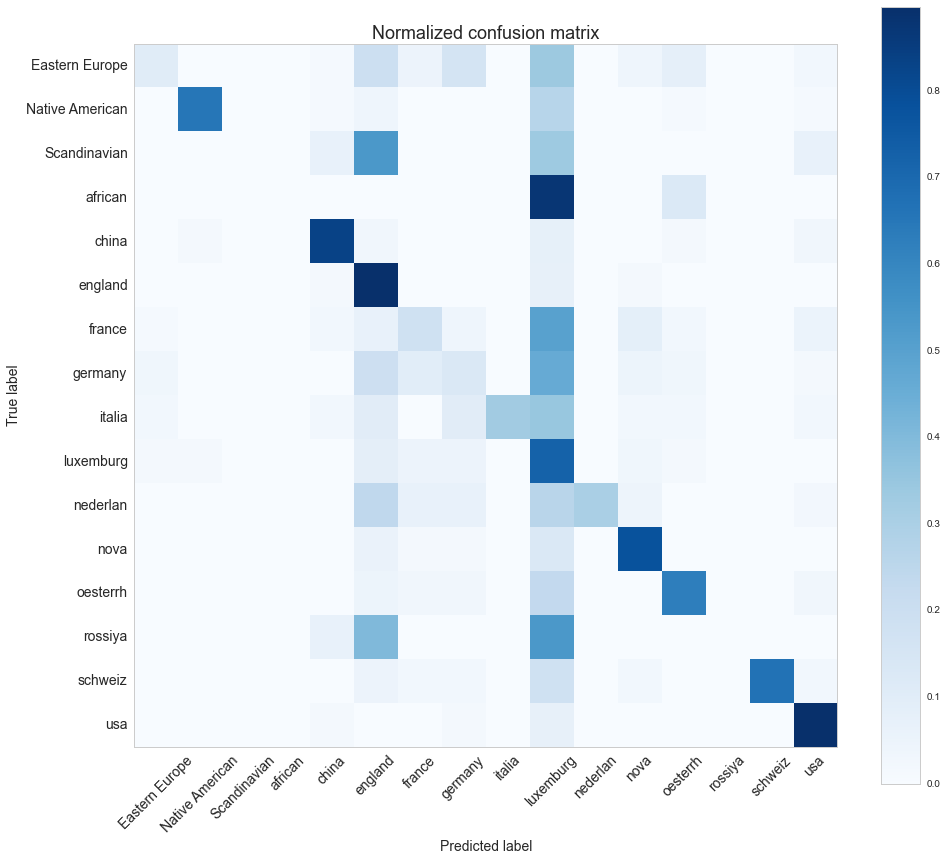

In [353]:
plt.figure(figsize=(14, 12))
plot_confusion_matrix(normalize_cm(cm), y_test, title='Normalized confusion matrix')

This has problems with balance - recall and precision. Need to explore the other models which perform better on test data.

In [321]:
# pressed for time - will make this a function for easier gridsearch on parameters

from sklearn.grid_search import GridSearchCV

from __future__ import print_function

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},{'kernel':['poly'],'degree':[1,2,3]}]

scores = ['accuracy']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, bal_both_count_list[6][2], test_size=0.33, random_state=44)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1, class_weight='balanced'), tuned_parameters, cv=3, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


Automatically created module for IPython interactive environment
# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.182 (+/-0.012) for {'kernel': 'rbf', 'C': 1, 'gamma': 1}
0.113 (+/-0.026) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.063 (+/-0.017) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.01}
0.063 (+/-0.018) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.065 (+/-0.016) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.379 (+/-0.022) for {'kernel': 'rbf', 'C': 10, 'gamma': 1}
0.469 (+/-0.012) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.1}
0.085 (+/-0.011) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
0.079 (+/-0.010) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.071 (+/-0.007) for {'kerne

In [322]:
tuned_parameters = [{'penalty': ['l2'], 'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}]
scores = ['accuracy']

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, 
                                                    bal_both_count_list[6][2], test_size=0.33, random_state=44)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(solver='newton-cg', n_jobs=-1, class_weight='balanced'), tuned_parameters, cv=3, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

Grid scores on development set:

0.480 (+/-0.016) for {'penalty': 'l2', 'C': 0.0001}
0.481 (+/-0.016) for {'penalty': 'l2', 'C': 0.001}
0.481 (+/-0.016) for {'penalty': 'l2', 'C': 0.01}
0.498 (+/-0.012) for {'penalty': 'l2', 'C': 0.1}
0.540 (+/-0.010) for {'penalty': 'l2', 'C': 1}
0.566 (+/-0.011) for {'penalty': 'l2', 'C': 10}
0.574 (+/-0.010) for {'penalty': 'l2', 'C': 100}
0.575 (+/-0.010) for {'penalty': 'l2', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

Eastern Europe     

0.613526570048


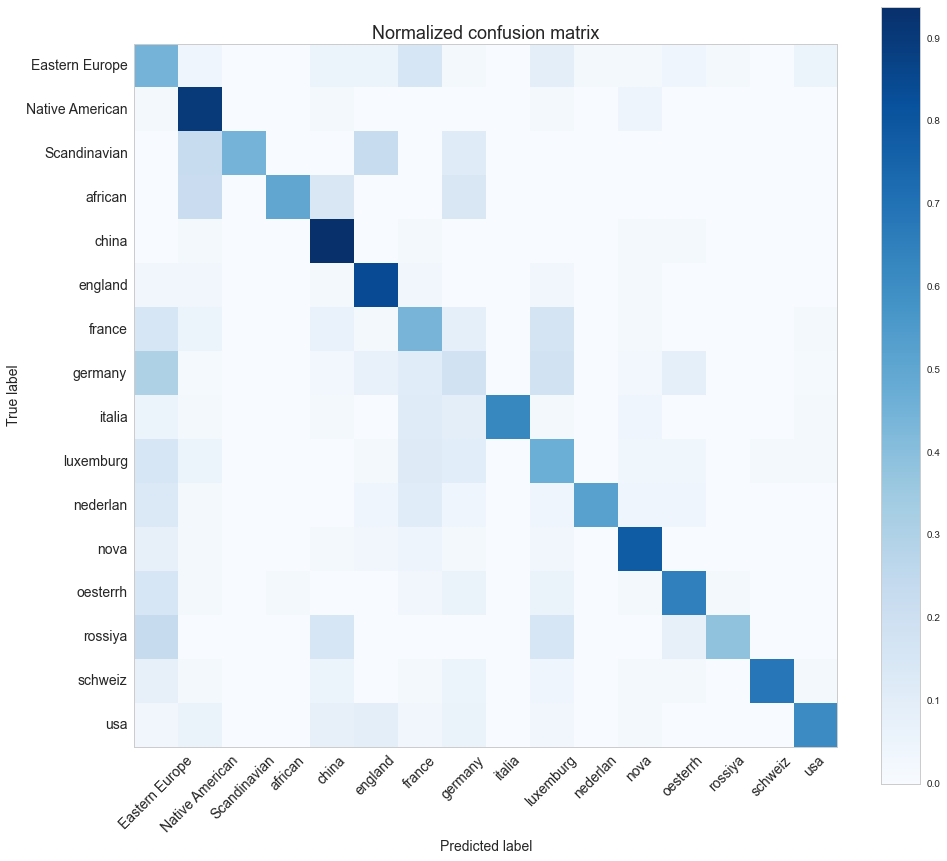

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, 
                                                    bal_both_count_list[4][2], test_size=0.33, random_state=44)

clf = LogisticRegression(solver='newton-cg', n_jobs=-1, class_weight='balanced', C=1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print (accuracy_score(y_test, pred))
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(14, 12))
plot_confusion_matrix(normalize_cm(cm), y_test, title='Normalized confusion matrix')
